In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# !cp gdrive/My\ Drive/x96/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 5995188
drwx------ 3 root root       4096 Apr 28 19:18 gdrive
drwx------ 2 root root       4096 Apr 28 19:20 models
drwxr-xr-x 1 root root       4096 Apr  4 20:20 sample_data
drwx------ 3 root root       4096 Apr 28 19:20 tools
-rw-r--r-- 1 root root     106539 Apr 28 20:38 weights1
-rw-r--r-- 1 root root     106539 Apr 28 20:42 weights2
-rw------- 1 root root  818509952 Apr 28 19:18 X_test.npy
-rw------- 1 root root 2619205760 Apr 28 19:19 X_train.npy
-rw------- 1 root root  654815360 Apr 28 19:19 X_val.npy
-rw------- 1 root root  409255040 Apr 28 19:19 y_test.npy
-rw------- 1 root root 1309602944 Apr 28 19:19 y_train.npy
-rw------- 1 root root  327407744 Apr 28 19:19 y_val.npy


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
import tools._my_tools as mt
import tools._torch_tools as tt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, X_val = mt.loadDataByOne("",train=True,val=True,typeF='float16',channels_last=False)

Device is cuda:0
Loading X_train.npy
Loading y_train.npy


In [21]:
X_val = mt.loadDataByOne("",val=True,typeF='float16',channels_last=False)[0]

Loading X_val.npy
Loading y_val.npy


In [0]:
import torchvision

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv2 = self._convBlock(1, 2, **self.conv_setup)
        self.conv4 = self._convBlock(2, 4, **self.conv_setup)
        self.conv8 = self._convBlock(4, 8, **self.conv_setup)
        self.conv16 = self._convBlock(8, 16, **self.conv_setup)
        
        self.conv16_16 = self._convBlock(16, 16, **self.conv_setup)

        self.upsample16 = self._upsampleBlock(self.upsample_layer, 16, 16, **self.conv_setup)
        self.deconv8 = self._convBlock(16, 8, **self.conv_setup)
        self.upsample8 = self._upsampleBlock(self.upsample_layer, 8, 8, **self.conv_setup)
        self.deconv4 = self._convBlock(8, 4, **self.conv_setup)
        self.upsample4 = self._upsampleBlock(self.upsample_layer, 4, 4, **self.conv_setup)
        self.deconv2 = self._convBlock(4, 2, **self.conv_setup)
        self.upsample2 = self._upsampleBlock(self.upsample_layer, 2, 2, **self.conv_setup)
        self.deconv1 = self._convBlock(2, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
    
    def encode(self, x):
        x2 = self.conv2(x)
        x2_p = self.pooling_layer(x2)
        
        x4 = self.conv4(x2_p)
        x4_p = self.pooling_layer(x4)
        
        x8 = self.conv8(x4_p)
        x8_p = self.pooling_layer(x8)
        
        x16 = self.conv16(x8_p)
        x16_p = self.pooling_layer(x16)
        
        return x16_p
    
    def decode(self,x):
        x = self.conv16_16(x)
        
        x = self.upsample16(x)
        x = self.deconv8(x)
        
        x = self.upsample8(x)
        x = self.deconv4(x)
        
        x = self.upsample4(x)
        x = self.deconv2(x)
        
        x = self.upsample2(x)
        x = self.deconv1(x)

        return x
        
    def forward(self, x):
        x = self.encode(x)

        x = self.decode(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

# model = Model().to(device)

# if device == torch.device("cpu"):
#     print(summary(model, (1,96,96)))
# else:
#     print(summary(model.cuda(), (1,96,96)))

In [0]:
model = Model()
# model.load_state_dict(torch.load("weights"))
# loss = VggLoss()
# loss = CombinedLoss()
training = tt.Training(model, device, X_train, X_train, X_val, X_val)

In [0]:
try:
    training.fit(128, 50, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 128
epochs : 50
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[1](1/2220): Loss: 0.1716	ETA 0:05:56	Epoch Loss: 0.1716

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[1](2220/2220): Loss: 0.0292	ETA 0:00:00	Epoch Loss: 0.0364
Epoch[1] finished in 0:03:34 with loss 0.036389266777582266
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0266
Validation loss = 0.0266

----------------------------

===> Epoch[2](2220/2220): Loss: 0.0263	ETA 0:00:00	Epoch Loss: 0.0253
Epoch[2] finished in 0:03:34 with loss 0.025278122034259477
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0234
Validation loss = 0.0234

----------------------------

===> Epoch[3](2220/2220): Loss: 0.0253	ETA 0:00:00	Epoch Loss: 0.0229
Epoch[3] finished in 0:03:34 with loss 0.02286608810326806
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0220
Validation loss = 0.0220

----------------------------

===> Epoch[4](2220/2220): Loss: 0.0247	ETA 0:00:00	Epoch Loss: 0.0217
Epoch[4] finished in 0:03:33 with loss 0.02168762100239595
Validating on 71040 samples.
===> Vali

In [0]:
!cp weights* gdrive/My\ Drive/14/.
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/14/.

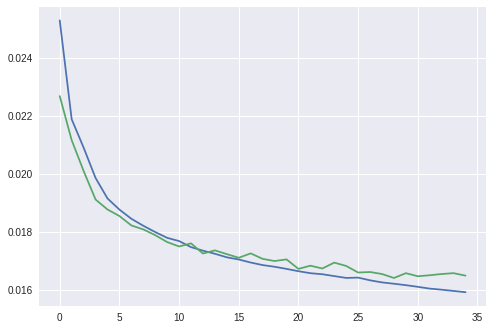

In [0]:
mt.plotHistory(training.history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


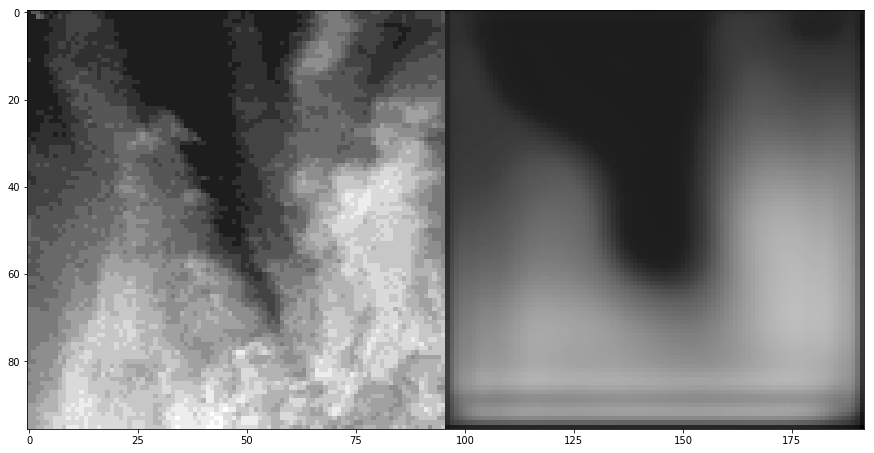

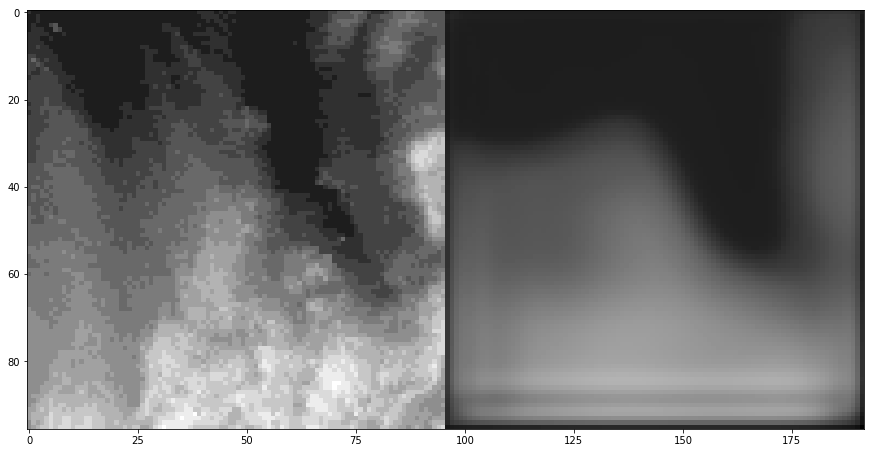

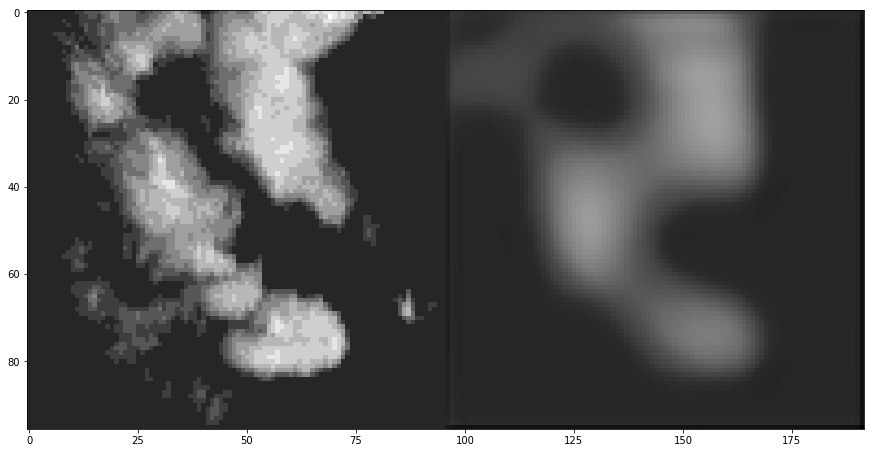

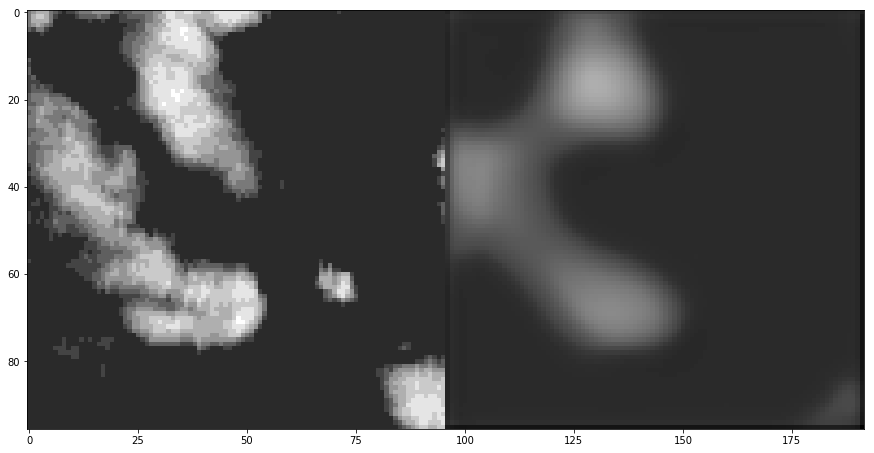

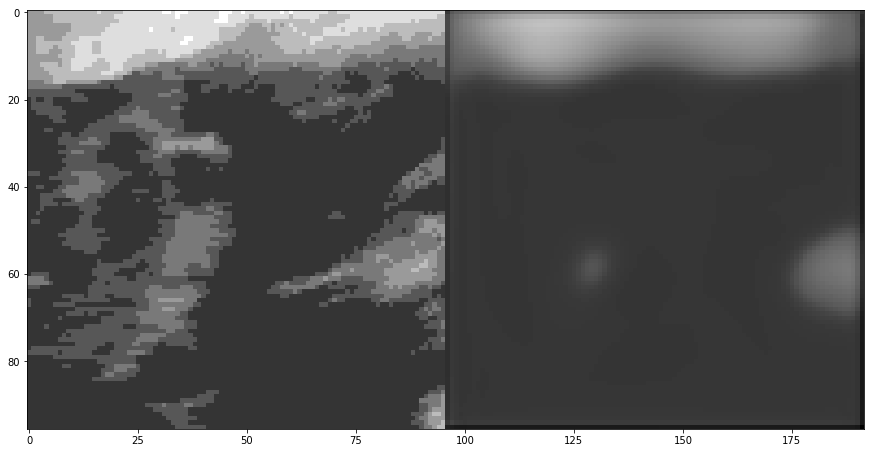

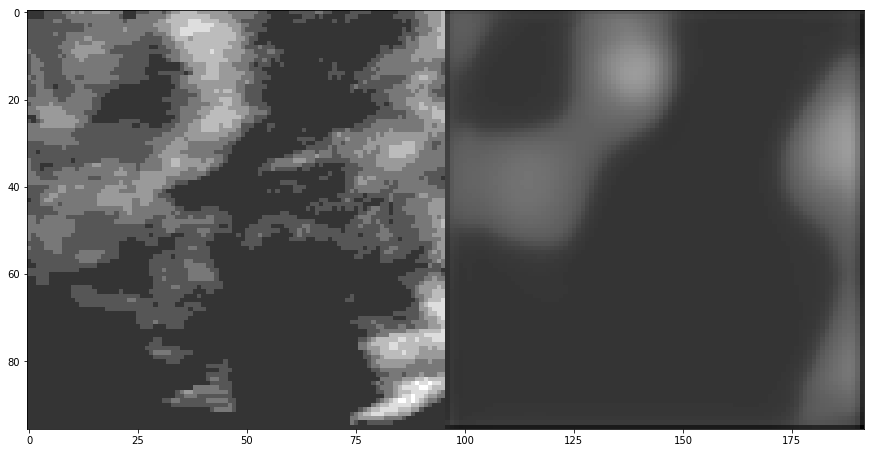

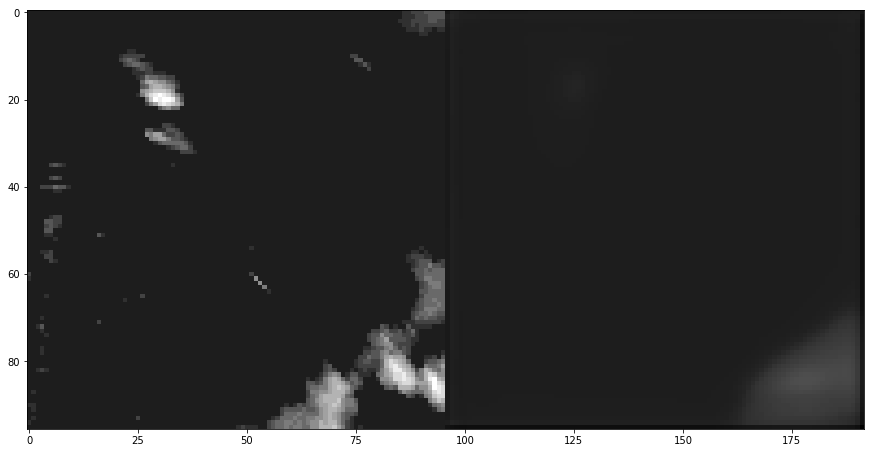

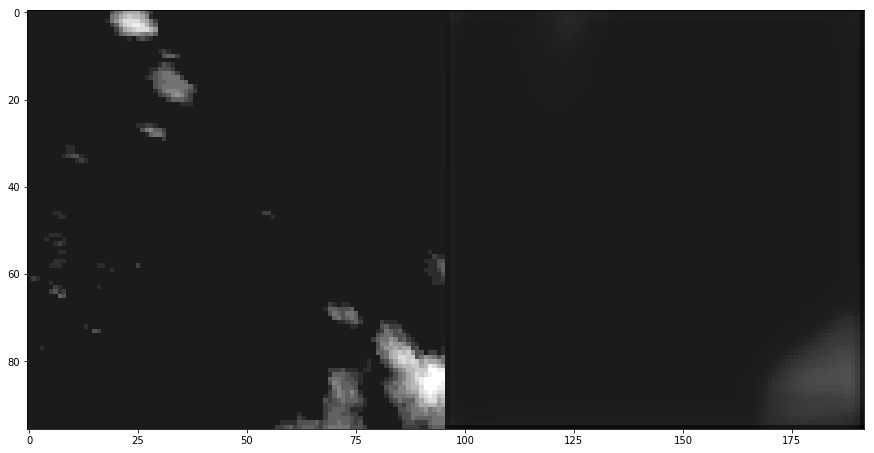

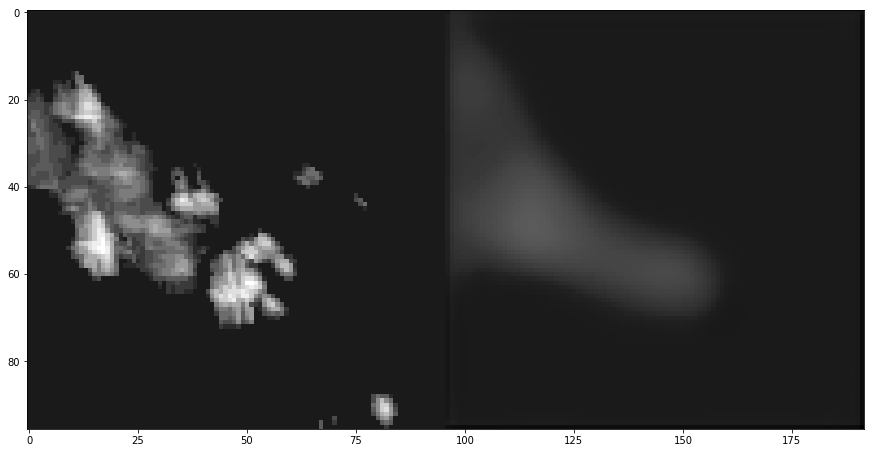

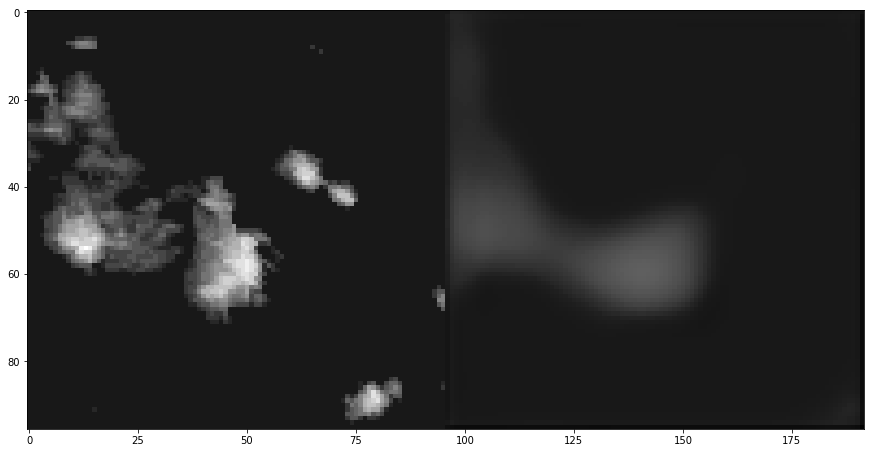

In [14]:
out = model( torch.tensor(X_train[0:10], dtype=torch.float).to(device) )

res = out.cpu().detach().numpy()
for i in range(10):
    mt.showImgGC(str(i).zfill(2),X_train[i,0,:,:],res[i,0,:,:],folder=None,size=(15,30))

In [0]:
torch.save(model.state_dict(), "weights")
# !cp weights gdrive/My\ Drive/weights3

In [0]:
model.load_state_dict(torch.load("weights5"))

In [0]:
!zip fig.zip *.png
# !zip weights.zip weights*

  adding: 00.png (deflated 1%)
  adding: 01.png (deflated 2%)
  adding: 02.png (deflated 8%)
  adding: 03.png (deflated 4%)
  adding: 04.png (deflated 1%)
  adding: 05.png (deflated 0%)
  adding: 06.png (deflated 2%)
  adding: 07.png (deflated 1%)
  adding: 08.png (deflated 3%)
  adding: 09.png (deflated 0%)


In [0]:
training.history = mt.fromCSV("history.csv")
training.history

In [0]:
from collections import defaultdict
import csv
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def showImgGC(name,*img,folder=None,size=(30,30)):
    if len(img) == 0:
        return
    else:
        res = img[0]
        for i in img[1:]:
            res = np.concatenate((res,i),axis=1)
            
    fig, ax = plt.subplots(figsize=size)
    ax.grid(False)
    ax.imshow(res.squeeze(), cmap='binary_r')
    if folder is not None:
        res = (res * 255).astype('int')
        cv.imwrite(folder+name+".png",res)